# Basic CNN model, Dr. Dimitris Mousadakos

### **1. Setup and Imports**

First, let's import the necessary libraries. We'll need `torch`, `torchvision`, `matplotlib`, and a few others.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, models, transforms
import requests
import zipfile
from pathlib import Path
from torchsummary import summary
import gdown
from tqdm.notebook import tqdm

### **2. Data Download and Preprocessing**

We'll download the "cats and dogs" dataset, which is a filtered version of the original dataset from Kaggle.

In [2]:
# 1. Download the dataset using the File ID
# We extract the ID from your URL: 19xX_Fr2x6NPlifcagIjxqUSWLE3Wtafw
file_id = '19xX_Fr2x6NPlifcagIjxqUSWLE3Wtafw'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'cats_and_dogs.zip'

gdown.download(url, output, quiet=False)

# 2. Extract the dataset
# We check if the file is a valid zip before extracting
if zipfile.is_zipfile(output):
    print("Extracting files...")
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall()
    print("Extraction complete.")
else:
    print("Error: The downloaded file is not a valid zip file.")

# 3. Define paths
PATH = Path('cat-and-dog-small/')
train_dir = PATH / 'training_set'
validation_dir = PATH / 'test_set'

Downloading...
From (original): https://drive.google.com/uc?id=19xX_Fr2x6NPlifcagIjxqUSWLE3Wtafw
From (redirected): https://drive.google.com/uc?id=19xX_Fr2x6NPlifcagIjxqUSWLE3Wtafw&confirm=t&uuid=da8b20ee-90e9-43ff-9419-6ad07972e2d5
To: /Users/dmousadakos/Library/CloudStorage/GoogleDrive-dmousadakos@bigblue.ai/My Drive/Teaching/HSLU/CVI03 - Blockweek/Computer Vision day 2/Exercises/cats_and_dogs.zip
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114M/114M [00:03<00:00, 30.5MB/s]


Extracting files...
Extraction complete.


In [3]:
! ls

Tensorflow                              torch_Pre_trained_models_exercise.ipynb
cat-and-dog-small                       torch_Transfer_Learning_exercise.ipynb
cats_and_dogs.zip                       torch_make_basic_CNN_model.ipynb


In [4]:
validation_dir

PosixPath('cat-and-dog-small/test_set')

Now, we'll set up data augmentation and loaders for our training and validation sets. Data augmentation is a key technique to prevent overfitting in computer vision tasks. 🖼️

In [5]:
# Image size and batch size
IMG_SIZE = (160, 160)
BATCH_SIZE = 32

# Data augmentation and normalization for training
# and just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the datasets
image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'val': datasets.ImageFolder(validation_dir, data_transforms['val'])
}

# Create dataloaders
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=BATCH_SIZE, shuffle=True),
    'val': DataLoader(image_datasets['val'], batch_size=BATCH_SIZE)
}

class_names = image_datasets['train'].classes
print(f"Classes: {class_names}")

Classes: ['cats', 'dogs']


Let's visualize some of the training images to get a feel for the data.



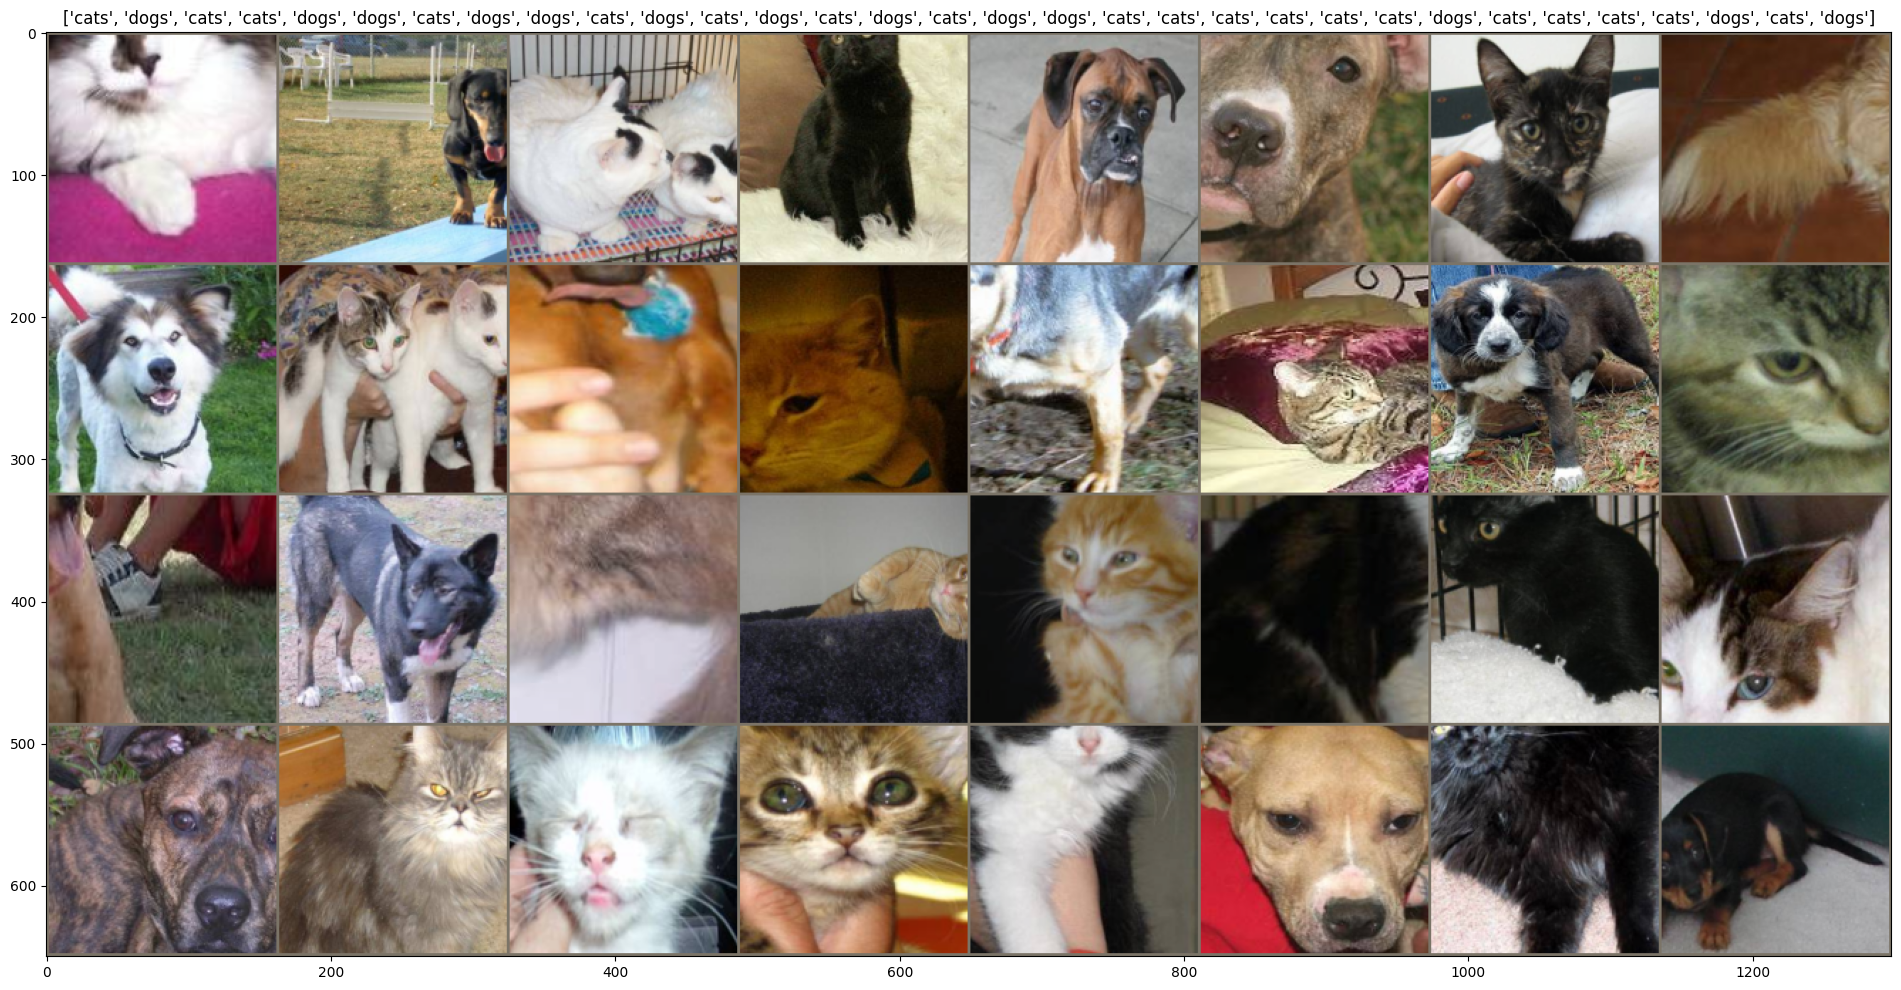

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    figsize=(50, 12)
    plt.figure(figsize=figsize)
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch and show images
from torchvision.utils import make_grid
out = make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

### **Part 1: Building a Simple CNN from Scratch**

Before we dive into transfer learning, let's establish a baseline. We will create a small Convolutional Neural Network (CNN) from scratch to see how well we can do on this problem without leveraging a pre-trained model.

This will help us understand the challenges of training a model from zero and will serve as a point of comparison for the performance of our transfer learning model later.

#### **Defining the CNN Architecture** 🧠

Our model will be simple, consisting of a few convolutional and pooling layers to extract features, followed by fully connected layers to perform the classification.

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        # Max Pooling Layer 1
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # Max Pooling Layer 2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully Connected Layer 1
        # The input features are calculated as 32 channels * 40 * 40 (image size after pooling)
        self.fc1 = nn.Linear(32 * 40 * 40, 512)
        # The output layer
        self.fc2 = nn.Linear(512, 2) # 2 classes: cat and dog

    def forward(self, x):
        # Apply layers with ReLU activation
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        # Flatten the tensor for the fully connected layer
        x = x.view(-1, 32 * 40 * 40)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
# Training function
def train_model(model, criterion, optimizer, num_epochs=10):
    # Initialize a dictionary to store training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Use tqdm to create a progress bar
            progress_bar = tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Epoch {epoch}')

            for inputs, labels in progress_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # Update progress bar with live accuracy (using .float())
                progress_bar.set_postfix(
                    loss=running_loss / ((progress_bar.n + 1) * dataloaders[phase].batch_size),
                    acc=running_corrects.float() / ((progress_bar.n + 1) * dataloaders[phase].batch_size)
                )

            # Calculate epoch metrics (using .float())
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.float() / len(image_datasets[phase])

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Record the loss and accuracy for this epoch
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                
    return model, history

def plot_history(history):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # --- Plot training & validation accuracy values ---
    ax1.plot(history['train_acc'], label='Train Accuracy', marker='o')
    ax1.plot(history['val_acc'], label='Validation Accuracy', marker='o')
    ax1.set_title('Model Accuracy Over Epochs', fontsize=16)
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='lower right')
    ax1.grid(True)

    # --- Plot training & validation loss values ---
    ax2.plot(history['train_loss'], label='Train Loss', marker='o')
    ax2.plot(history['val_loss'], label='Validation Loss', marker='o')
    ax2.set_title('Model Loss Over Epochs', fontsize=16)
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(loc='upper right')
    ax2.grid(True)

    plt.show()

In [9]:
simple_model = SimpleCNN().to('cpu')
# Define the input size (channels, height, width)
input_size = (3, 160, 160)

# Generate the summary, telling it to use the correct device
summary(simple_model.to('cpu'), input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 160, 160]             448
         MaxPool2d-2           [-1, 16, 80, 80]               0
            Conv2d-3           [-1, 32, 80, 80]           4,640
         MaxPool2d-4           [-1, 32, 40, 40]               0
            Linear-5                  [-1, 512]      26,214,912
            Linear-6                    [-1, 2]           1,026
Total params: 26,221,026
Trainable params: 26,221,026
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.29
Forward/backward pass size (MB): 5.86
Params size (MB): 100.03
Estimated Total Size (MB): 106.18
----------------------------------------------------------------


In [10]:
# Move the model to the GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("✅ Using NVIDIA GPU (CUDA)")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ Using Apple Silicon GPU (MPS)")
else:
    device = torch.device("cpu")
    print("✅ Using CPU")

# Move the model to the selected device
simple_model = SimpleCNN().to(device)

✅ Using Apple Silicon GPU (MPS)


#### **Training the Simple CNN**

Now, let's train this model for a few epochs using the same training loop we defined. Notice that we are training *all* the parameters from scratch.

In [11]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simple_model.parameters(), lr=0.001)

# Train the model
# (We are reusing the 'train_model' function from before)
simple_model, simple_history = train_model(simple_model, criterion, optimizer, num_epochs=10)

Epoch 0/9
----------


Train Epoch 0:   0%|          | 0/126 [00:00<?, ?it/s]

train Loss: 0.8568 Acc: 0.5504


Val Epoch 0:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.6632 Acc: 0.5830
Epoch 1/9
----------


Train Epoch 1:   0%|          | 0/126 [00:00<?, ?it/s]

train Loss: 0.6629 Acc: 0.5907


Val Epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.6328 Acc: 0.6551
Epoch 2/9
----------


Train Epoch 2:   0%|          | 0/126 [00:00<?, ?it/s]

train Loss: 0.6396 Acc: 0.6361


Val Epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.6196 Acc: 0.6660
Epoch 3/9
----------


Train Epoch 3:   0%|          | 0/126 [00:00<?, ?it/s]

train Loss: 0.6213 Acc: 0.6581


Val Epoch 3:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.6190 Acc: 0.6611
Epoch 4/9
----------


Train Epoch 4:   0%|          | 0/126 [00:00<?, ?it/s]

train Loss: 0.6135 Acc: 0.6663


Val Epoch 4:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.6271 Acc: 0.6640
Epoch 5/9
----------


Train Epoch 5:   0%|          | 0/126 [00:00<?, ?it/s]

train Loss: 0.6086 Acc: 0.6706


Val Epoch 5:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.5840 Acc: 0.6927
Epoch 6/9
----------


Train Epoch 6:   0%|          | 0/126 [00:00<?, ?it/s]

train Loss: 0.5966 Acc: 0.6776


Val Epoch 6:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.6125 Acc: 0.6601
Epoch 7/9
----------


Train Epoch 7:   0%|          | 0/126 [00:00<?, ?it/s]

train Loss: 0.5839 Acc: 0.6928


Val Epoch 7:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.6056 Acc: 0.6937
Epoch 8/9
----------


Train Epoch 8:   0%|          | 0/126 [00:00<?, ?it/s]

train Loss: 0.5769 Acc: 0.6908


Val Epoch 8:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.5682 Acc: 0.6937
Epoch 9/9
----------


Train Epoch 9:   0%|          | 0/126 [00:00<?, ?it/s]

train Loss: 0.5809 Acc: 0.6871


Val Epoch 9:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.5881 Acc: 0.6877


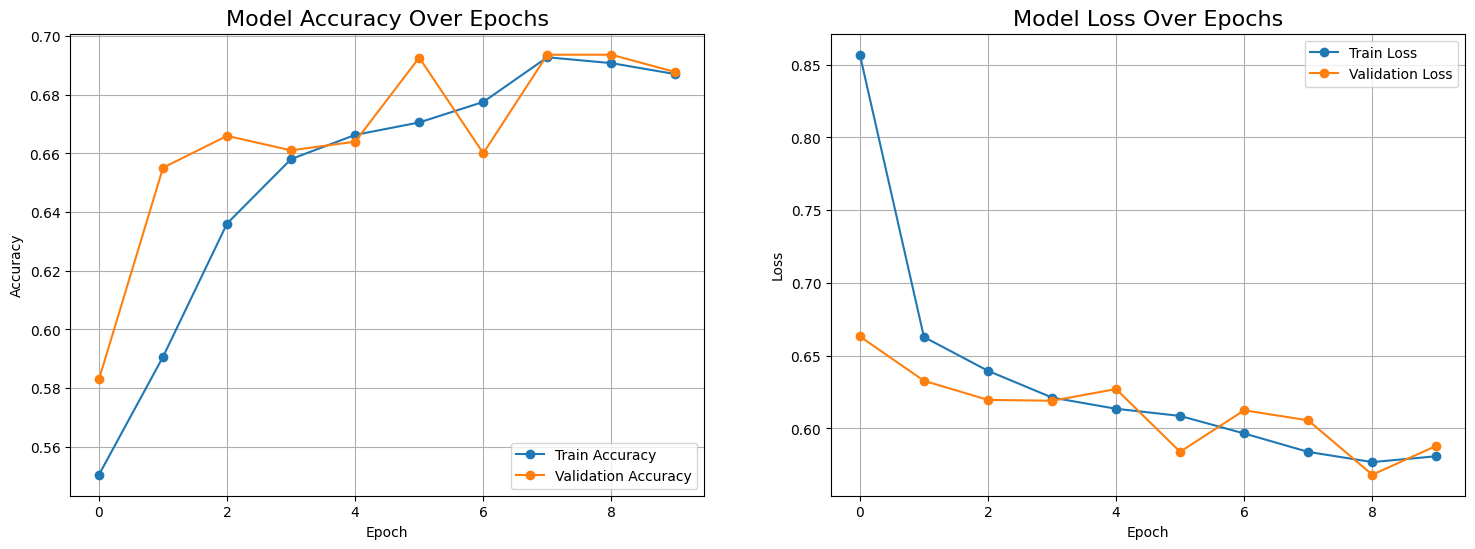

In [12]:
# Plot the training history
plot_history(simple_history)

### CNN Architecture
* Try to tune the parameters, change the architecture.
* How the accuracy is changing?

#### **🤔 Analyze the Results**

After the training is complete, take a close look at the accuracy and loss graphs.

* How high did the validation accuracy get?
* Is the model showing signs of overfitting?
* How does its performance compare to a model that has learned from millions of images already?